# Projet Simulation Numérique ENSEEIHT 2022-2023
### Groupe: B2
### Nom: CHARIFI
### Prénom: Yasmine
### Commentaire: 

# Informations pratiques

**Modalités pédagogiques** 

Le projet Simulation Numérique vise à vous faire découvrir un algorithme particulier en lien avec d'autres modules d'enseignement de cette année et d'illustrer certaines notions et propriétés à partir de programmes simples que vous devez écrire ou bien compléter. Le langage de programmation proposé est Python. Une connaissance basique de Python et de Numpy est suffisante. 

Cette année, il vous est demandé en premier lieu un travail de compréhension des algorithmes principaux sur la base du C/TD du 10/3/23 et des liens en fin de Notebook. Ensuite est demandé un travail d'implantation informatique simple (partie A) et quelques applications sur des images vous sont proposées (partie B). Ce travail est notamment guidé, des questions de compréhension sur les algorithmes sont posées en Partie C. La partie D vous permet d'implanter un algorithme populaire à titre de comparaison. Le volume de travail demandé est raisonnable.

**Enseignement**

Voici les informations concernant les séances (date, heure):

10/3/23 14.00-16.00 C/TD Groupes B1 et B2 (B306)

14/3/23 14.00-18.00 TP Groupe B1 (C306)

17/3/23 08.00-12.00 TP Groupe B2 (C203)

24/3/23 14.00-16.00 TD Séance de réponse à vos questions (B306)

**Evaluation**

L'évaluation se basera uniquement sur le Notebook que vous devrez rendre. 

**Date limite de rendu**:  19 avril 2023 à midi. 

**Contact**: xavier.vasseur@irit.fr

Merci d'indiquer [PSN] en sujet de votre email pour m'aider à identifier vos requêtes.

**Préambule** L'objectif de ce projet est d'analyser quelques algorithmes de factorisation structurée (déterministe ou aléatoire) de matrices de grande taille. Nous nous intéressons à des algorithmes de factorisation dits "Interpolative Decomposition (ID)" ou "CUR-ID", où l'on cherche à approcher au mieux une matrice en un produit de matrices de rang faible. Les algorithmes seront comparés si possible sous différents angles: temps de calcul, complexité opératoire, précision numérique notamment. Nous envisagerons également l'utilisation d'algorithme dit de factorisation non-négative en fin de projet.

**NB:** Il vous est demandé d'insérer vos commentaires et codes **uniquement** dans ce fichier Notebook. Vous avez toute liberté pour créer des cellules soit de texte soit de code. Vous devez disposer comme données de ce fichier et de quelques images au format .jpg. Le rendu sera uniquement ce fichier Notebook dans lequel vous devez insérer l'ensemble de vos résultats. 

Ce projet est en lien notamment avec les cours suivants:

   * Calcul scientifique
   * Algèbre linéaire pour le data mining
   * Optimisation II

In [1]:
#
# Chargement des bibliotheques pour la visualisation, l'algebre lineaire et l'analyse du temps de calcul 
#
import matplotlib.pyplot as plt
import numpy as np
from   scipy import fftpack
from   scipy.linalg import qr, norm, solve_triangular, svd
from   PIL import Image
import time

### Introduction.

L'approximation de rang faible que nous utiliserons dans ce projet se base sur une connaissance du rang exact ou du rang approché de la matrice étudiée. A titre informatif, la méthode suivante vous permet d'obtenir une majoration du rang d'une matrice rectangulaire $A$ telle que $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$, $\epsilon$ désignant une tolérance choisie par l'utilisateur. Cette méthode sera donc utile par la suite dans vos expérimentations numériques, aucune modification n'est a priori requise. 


In [2]:
def adaptive_rank_determination(A,epsilon,blocking=16,iteration_max=10):
    """
    Adaptive rank determination based on randomization
    We look for an orthogonal matrix Q such that 
    $\|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    where $\|.\|_F$ denotes the Frobenius norm.
    
    Reference: Adapted from Section 12 of P.G. Martinsson, "Randomized methods for matrix computations", 2019, 
    ArXiv 1607.01649 [https://arxiv.org/pdf/1607.01649.pdfs]. The original algorithm corresponds to 
    Figure 12. 
    
    Input: 
    A:        matrix to be analysed [array type] (of shape (m,n))
    epsilon:  relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    blocking: blocking parameter to be used in the implementation (for efficiency reasons) [int]
    
    Output:
    Q: matrix with orthonormal columns such that $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    erank: estimated rank (upper bound of epsilon-rank(A)), erank is here a multiple of min(blocking,n). 
    ratio: current ratio of $\|A - Q Q^T A \|_F4$ divided by $\|A \|_F$
    iteration: nombre d'itérations réalisé au sein de l'algorithme
    """ 
    
    m, n          = A.shape[:]
    # The blocking parameter should be less than the number of columns
    b             = min(blocking,n)
    iteration     = 0
    # Update the maximal number of iterations according to b
    iteration_max = max(np.ceil(n/b),iteration_max) 
    norm_A_Fro = norm(A,'fro')
    
    while norm(A,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        # Create R the random block based on Gaussian variables
        R      = np.random.randn(n,b)
        # Matrix-matrix product Y = AR 
        Y      = A@R
        # QR decomposition of Y
        QY, RY = qr(Y,mode='economic')
        # Compute the projection 
        BY     = QY.T@A
        # Concatenate the information related to Q and B
        if iteration == 0:
            Q  = QY
            B  = BY
        else:
            Q  = np.concatenate((Q, QY),axis=1)
            B  = np.concatenate((B, BY),axis=0)
        # Update the iteration count
        iteration += 1
        # Update of A
        A = A - QY@BY
        # Upper bound of epsilon-rank
        erank = Q.shape[1]
        
    return Q, Q.shape[1], norm(A,'fro')/norm_A_Fro, iteration

## Partie A.1

Proposer une implantation des différents algorithmes de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie C). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [3]:
def column_ID(A,k):
    """
    Compute a column interpolative decomposition such that 
    A \approx A[:,J] Z
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    J  is the set of column indices [array, any type] (of shape k)
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    Z    = np.zeros(shape=(k,n))
  
    #
    # TO DO
    #
    # Perform the economic decomposition of A with column pivoting 
    [Q,R,P] = qr(A,mode='economic',pivoting=True)
    
    # Deduce the T=R11^{-1}R12 block 
    T = solve_triangular(R[:k,:k],R[:k,k:n])
    
    # Deduce J and Z 
    J = P[:k]
    Z[:,P] =np.concatenate((np.eye(k),T),axis =1)
    #
    # END TO DO
    #
    
    return J,Z


def row_ID(A,k):
    """
    Compute a row interpolative decomposition such that 
    A \approx X A[I,:] 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array, any type] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k))
    
    #
    # TO DO
    #
    
    # Perform the economic decomposition of A^T with column pivoting 
    [Q,R,J] = qr(np.transpose(A),mode='economic',pivoting=True)
    
   # Deduce the corresponding T block 
    T = solve_triangular(R[:k,:k],R[:k,k:m])
    
    # Deduce I and X 
    X[J,:] = np.transpose(np.concatenate((np.eye(k),T),axis =1))
    I = J[:k]
    #
    
    #
    # END TO DO
    #
    
    return I,X

def double_sided_ID(A,k):
    """
    Compute a double sided interpolative decomposition such that 
    A \approx X A(I,J) Z 
    
    Input: 
    A matrix to be analysed [array type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array] (of shape k)
    J  is the set of column indices [array] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO
    #
    
    # Apply the column ID to A
    J,Z = column_ID(A,k)
    
    # Apply the row ID to A[:,J]
    I,X = row_ID(A[:,J],k)
    
    #
    # END TO DO
    #
    
    return I,J,X,Z

def extract_subblock(A,I,J):
    """
    Given a set of row and column indices, extract the submatrix 
    B = A[I,J]
    with I the set of row indices and J the set of column indices.
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    I  is the set of row indices  (of shape k)
    J  is the set of column indices  (of shape k)
    
    Output:
    Matrix A[I,J] [array] (of shape (k,k))
    """
    B = np.zeros(shape=(len(I),len(J)))
    row_index = 0
    
    for i in I:
        col_index = 0
        for j in J:
            B[row_index,col_index] = A[i,j]
            col_index = col_index + 1
            
        row_index = row_index + 1
    
    return B

def cur(A,k):
    """
    Deterministic version of the CUR algorithm based on the 
    double sided ID decomposition. 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO
    #
    
    # Apply the double sided interpolation algorithm 
    
    I,J,X,Z = double_sided_ID(A,k)
    
    # Deduce the C and R matrices of the CUR formulation 
    
    C = A[:,J]
    R = A[I,:]
    # Solve U R = Z in a least-squares sense
    U = Z @ np.linalg.pinv(R)
    #
    # END TO DO
    #
    return I,J,C,U,R

## Partie A.2 

Proposer une implantation des différents algorithmes aléatoires de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie D). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [4]:
def randomized_row_ID(A,k,p=10,q=2):
    """
    Randomized version of the row ID to decompose matrix A into
    A \approx X A(I,:) 
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)
    
    Output:
    I  is the set of row indices  (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.4 and Figure 8 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    
    """
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k)) 
    
    # Use the randomized variant to construct Y an approximation of A
    G    = np.random.randn(n,k+p)
    Y    = A@G
   
    #
    # TO DO
    #
    for j in range(1,q+1) :
        Z = Y@np.transpose(A)
        Y = Z@A

    
    # Apply the row ID algorithm to Y
    
    I,X = row_ID(Y,k)
    
    #
    # END TO DO
    #
    
    return I,X

   
def randomized_cur(A,k,p=10,q=2):
    """
    Randomized version of the CUR algorithm     
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 and Figure 10 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """    
    m, n = A.shape[:]
    
    # Randomized version starts here
    # Use the randomized variant to construct Y an approximation of A
     
    G    = np.random.randn(k+p,m)
    Y    = G@A
    
    #
    # TO DO
    #
    for i in range(1,q+1):
        Z = Y@np.transpose(A)
        Y = Z@A
        
    # Apply the column ID algorithm to Y 
    [J,Z] = column_ID(Y,k)
    
    
    # Apply the row ID algorithm to A[:,J]
    
    I,X = row_ID(A[:,J],k)
        
    # Deduce the CUR matrices (C, R and then U)
    C = A[:,J]
    R = A[I,:]
    # Solve U R = Z in a least-squares sense
    U = Z @ np.linalg.pinv(R)
    
    #
    # END TO DO
    #
    return I,J,C,U,R

## Partie B

Nous cherchons à mettre en oeuvre les algorithmes précédents sur une application liée à la reconstruction d'images.
La cellule suivante vous montre comment charger une image et en déduire la matrice associée. Appliquer alors les algorithmes de 
factorisation vus en Partie A et visualiser les images obtenues en fonction du rang estimé.  

### Sydney

(396, 563)


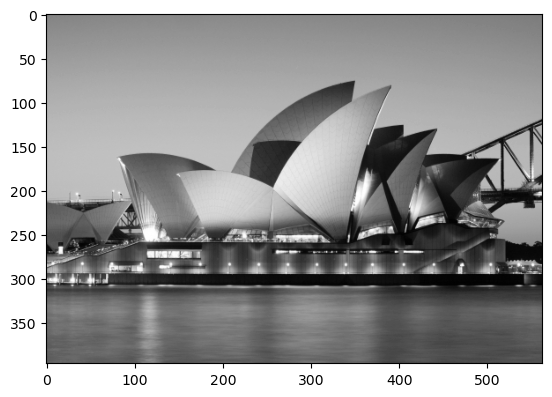

In [5]:
#
# Lecture de l'image 
#
#
imgc = Image.open("Sydney_Opera_House.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Sydney = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.07744908332824707
Estimated upper bound of the epsilon-rank:  80  for relative threshold:  0.05
Frobenius norm ratio:  0.04968397819166959  reached in  5 iterations
Time spent in the CUR algorithm 0.07232928276062012
Time spent in the randomized CUR algorithm 0.024486541748046875
Time spent in the double sided ID algorithm 0.037044525146484375


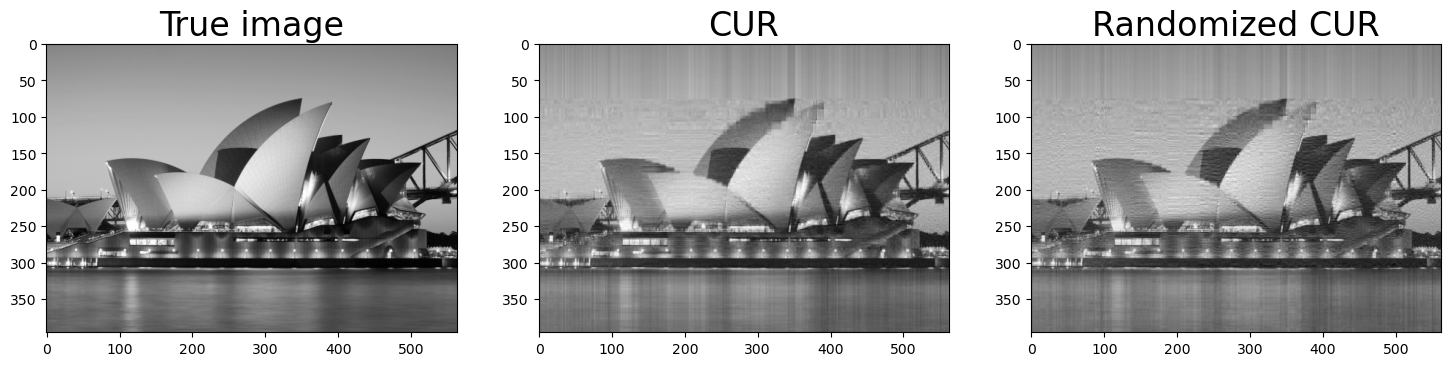

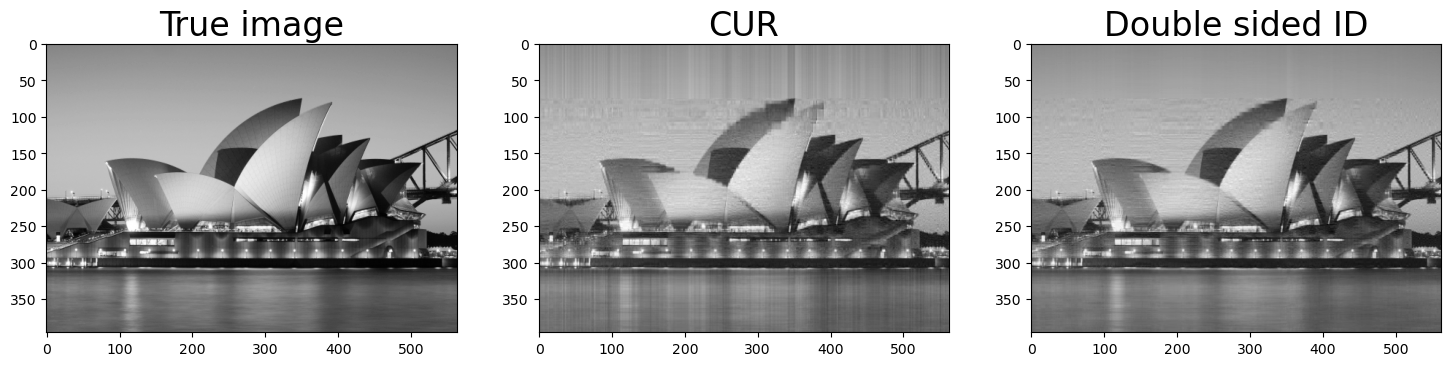

In [6]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Sydney = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_S          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_S,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Tokyo

(1008, 1212)


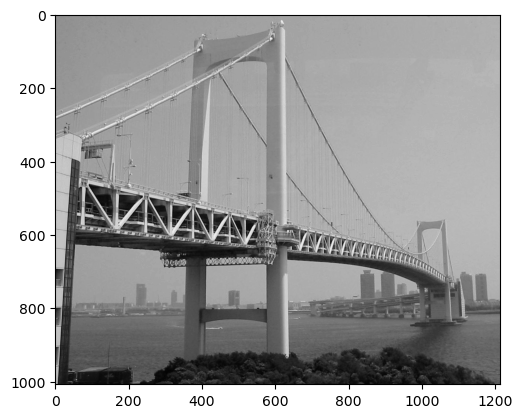

In [7]:
#
# Lecture de l'image 
#
#
#imgc = Image.open("Sydney_Opera_House.jpg")
imgc = Image.open("Tokyo_Rainbow_Bridge.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Tokyo  = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.2092142105102539
Estimated upper bound of the epsilon-rank:  160  for relative threshold:  0.05
Frobenius norm ratio:  0.04723835186451833  reached in  10 iterations
Time spent in the CUR algorithm 0.41158413887023926
Time spent in the randomized CUR algorithm 0.10443353652954102
Time spent in the double sided ID algorithm 0.41901683807373047


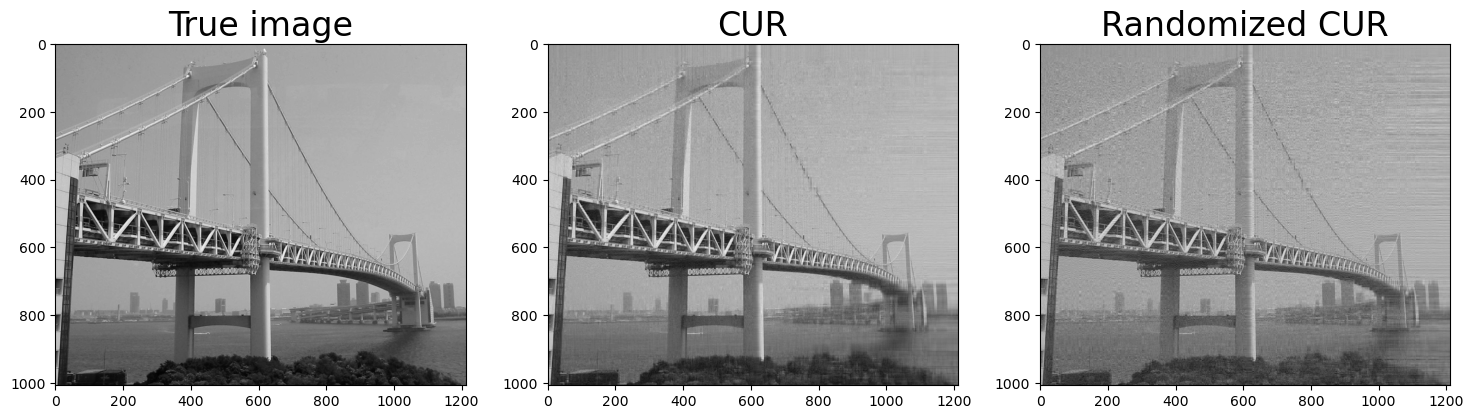

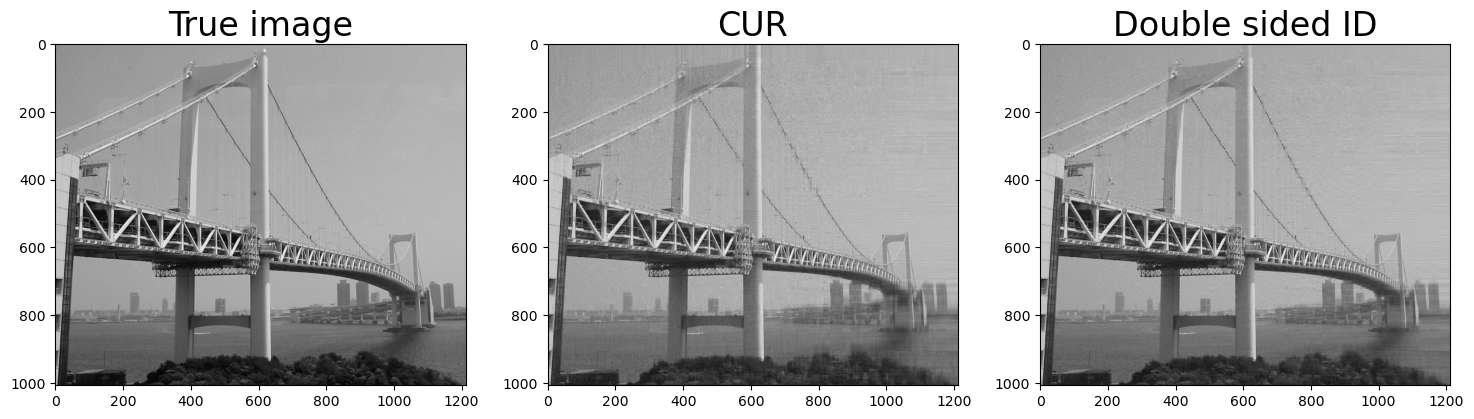

In [8]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Tokyo = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_T          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_T,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Hamburg

(524, 932)


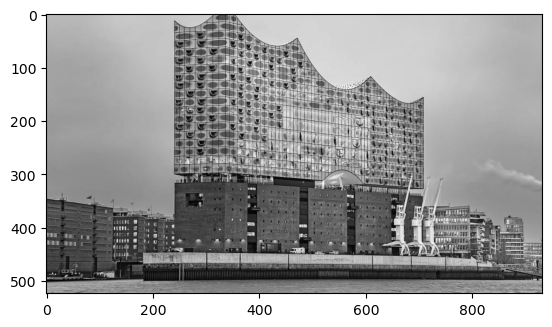

In [9]:
#
# Lecture de l'image [couleur] 
#
#
imgc = Image.open("Hamburg_Elbphilarmonie.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M         = (1./255)*np.array(img_gray)
M_Hamburg = M[:]

print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.17110991477966309
Estimated upper bound of the epsilon-rank:  272  for relative threshold:  0.05
Frobenius norm ratio:  0.04734049259871755  reached in  17 iterations
Time spent in the CUR algorithm 0.1608738899230957
(272, 932)
Time spent in the randomized CUR algorithm 0.12757420539855957
(272, 932)
Time spent in the double sided ID algorithm 0.16977429389953613
(272, 932)


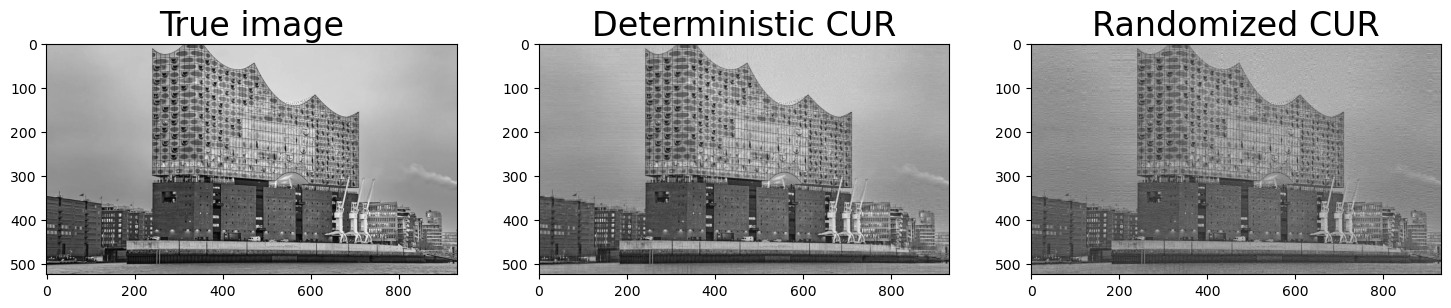

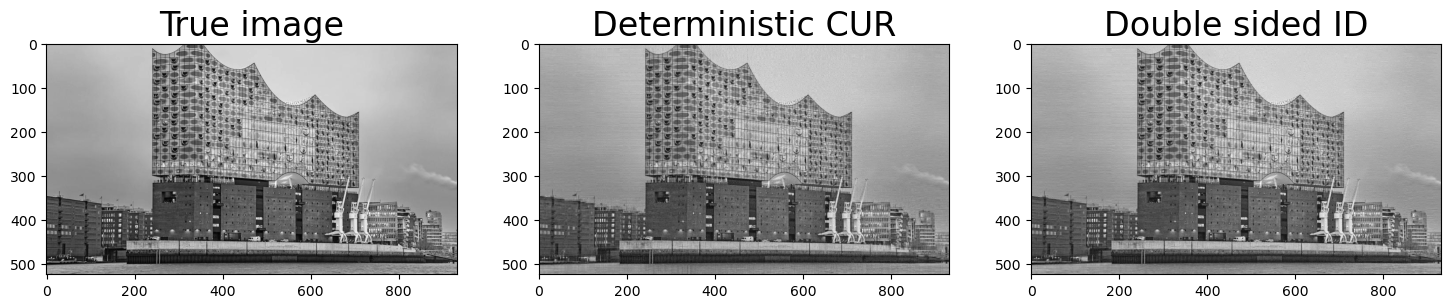

In [10]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Hamburg = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
print(np.shape(R))
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I,J,C, U, R    = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
print(np.shape(R))
#
# Double sided ID
#
t_start  = time.time()
I,J,X,Z  = double_sided_ID(M,erank)
JID_H    = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
print(np.shape(Z))
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_H,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

**Question:**
* B.1 Prenez trois valeurs pour $\epsilon$ (par exemple $\epsilon=0.5$, $\epsilon=0.1$ et $\epsilon=0.05$) et analysez la qualité de l'approximation pour les images considérées. Qu'observez-vous ? 

**Réponse**:
La qualité de l'approximation est meilleure lorsque la valeur de $\epsilon$ est plus petite. En effet,on peut voir d'aprés le graphe qui suit que plus la valeur de $\epsilon$ est petite, plus l'approximation est proche à l'image d'origine.

**Question:**
* B.2 Observez-vous des différences de qualité de reconstruction entre les algorithmes pour une précision identique ?

**Réponse**:
D'aprés les images obtenues, on peut conclure que la qualité de la reconstruction est meilleure pour le double sided ID, et pire pour le randomized CUR.


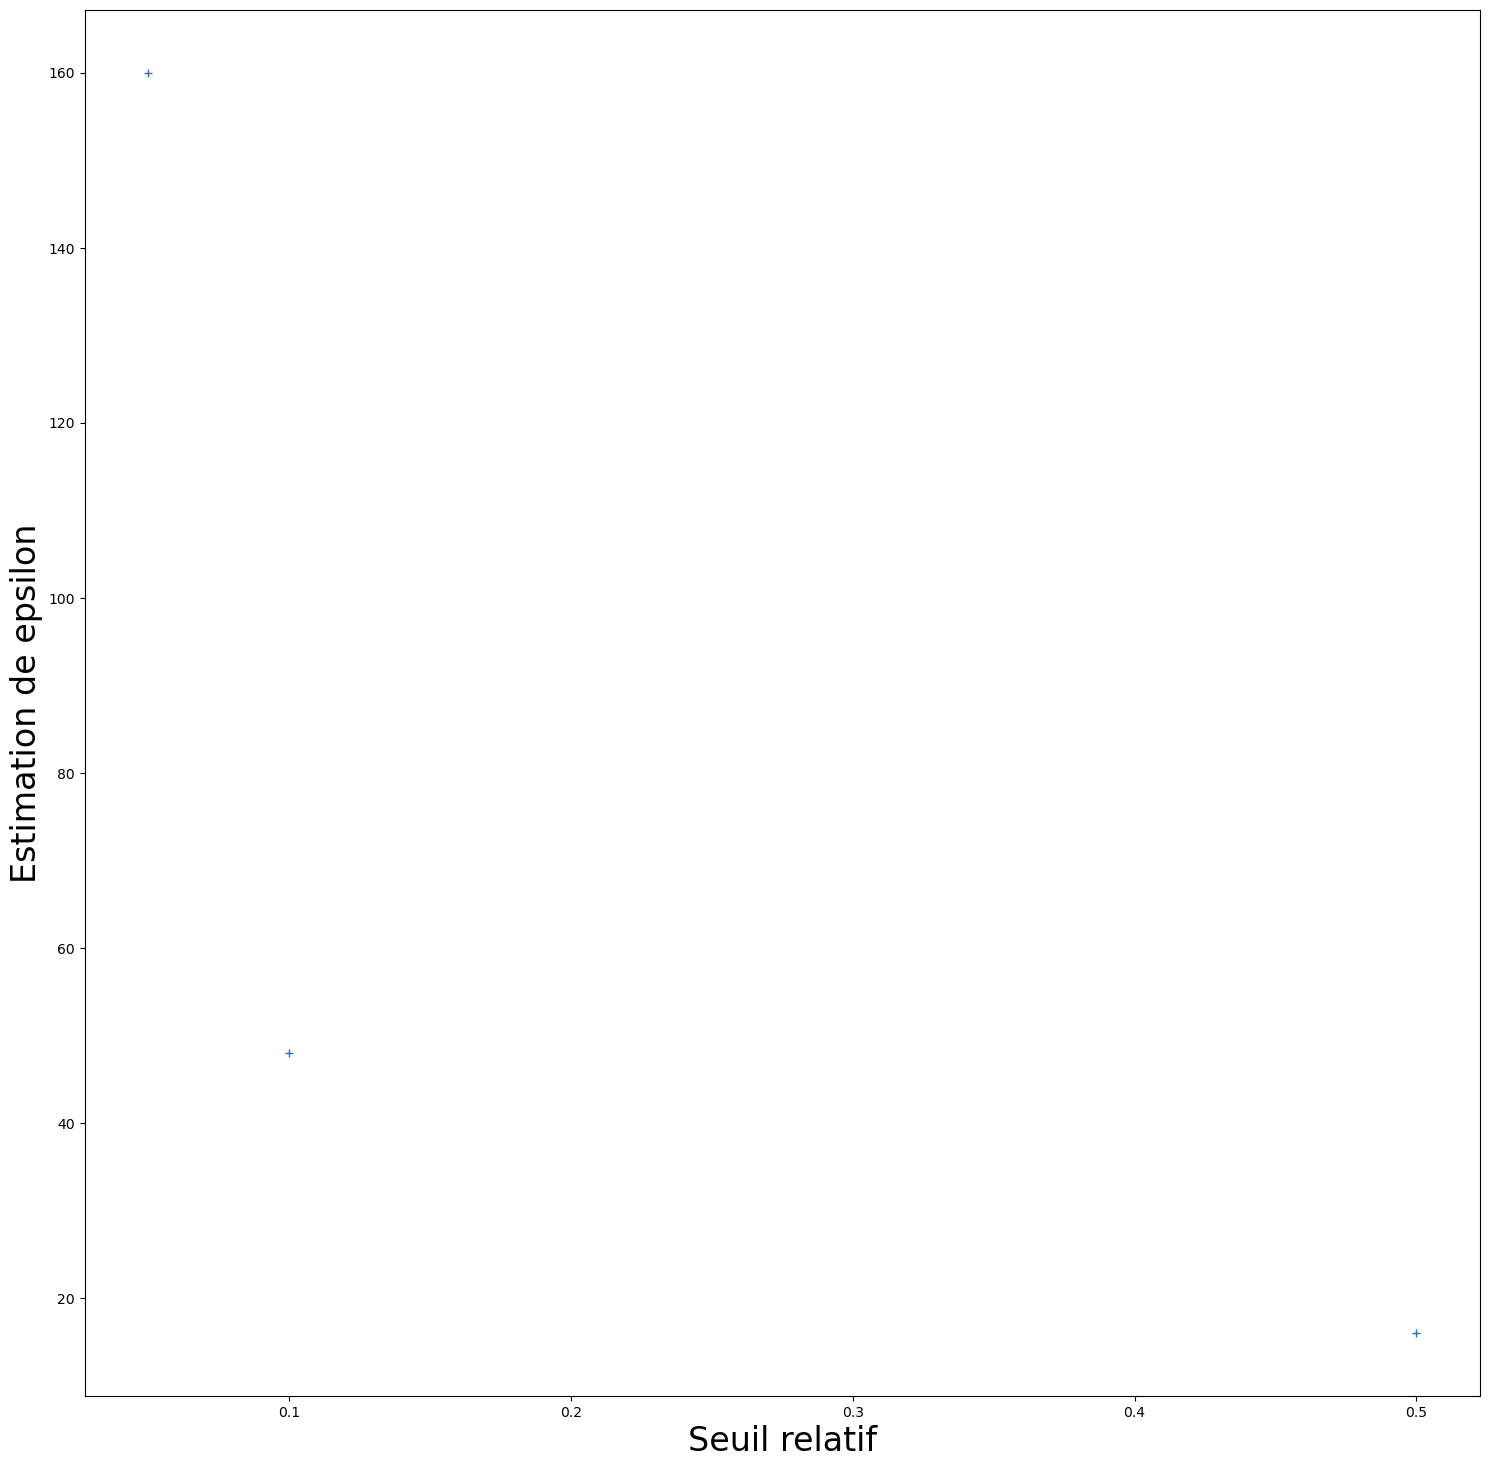

In [16]:
epsilon = [0.5, 0.1, 0.05]
erank   = np.zeros(np.shape(epsilon))
for i in range(np.shape(epsilon)[0]):
    Q, erank[i], norm_ratio, iteration = adaptive_rank_determination(M,epsilon[i],blocking)

plt.figure(figsize=(18,18))
plt.plot(epsilon,erank,'+')
plt.xlabel('Seuil relatif',fontsize=24)
plt.ylabel('Estimation de epsilon',fontsize=24)
plt.show()

## Partie C.

En vous basant notamment sur les notes de cours, le chapitre 11 de <a href="https://arxiv.org/pdf/1607.01649.pdf">Martinsson (2019)</a>, la section 13 de <a href="https://arxiv.org/pdf/2002.01387.pdf">Martinsson et Tropp (2020)</a>,  répondre aux deux questions suivantes:

* C.1 Donner les avantages et inconvénients éventuels de la décomposition déterministe CUR-ID. 

**Réponse**:
L'algorithme CUR-ID présente plusieurs avantages par rapport à l'algorithme ID. Tout d'abord, il est plus précis dans l'approximation de données. De plus, il est plus efficace en termes de temps de calcul, ce qui est un avantage important pour les applications en temps réel ou les grandes bases de données.

Cependant, l'algorithme CUR-ID présente également un inconvénient majeur, à savoir sa complexité accrue par rapport à l'algorithme ID. La mise en œuvre de l'algorithme CUR-ID peut nécessiter des ressources computationnelles plus importantes, ce qui peut limiter son utilisation dans certaines applications où l'efficacité de calcul est cruciale.

* C.2 Expliquer comment paralléliser l'algorithme aléatoire CUR-ID. 

**Réponse**:
Pour paralléliser l'algorithme CUR-ID, on peut utiliser la méthode suivante : diviser la matrice en blocs et calculer la décomposition CUR de chaque bloc en parallèle. Ensuite, on peut calculer le produit des blocs. En effet, cet algorithme est principalement composé de multiplication de matrices, il est donc possible de le paralléliser en utilisant un algorithme de multiplication de matrices parallèles et une carte graphique (GPU) serait idéale pour cela. Les GPU sont très efficaces pour la multiplication de matrices.

## Partie D.

Appliquer l'algorithme de factorisation non-négative de <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Lee et Cheung</a> (Théoreme 1) pour obtenir une approximation d'une image donnée en norme de Frobenius. Une attention sera donnée à l'implantation proposée et au temps de restitution obtenu.  Vous pourrez à cet effet utiliser les fonctions multiply et divide de NumPy.

In [11]:
def nmf(M,erank,epsilon,iteration_max):
    """
    Non-negative matrix factorization for matrix M.
    Input: 
    M:             matrix to be analysed [array type] (of shape (m,n))
    erank:         estimated rank (upper bound of epsilon-rank(M))
    epsilon:       relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    iteration_max: maximal number of iterations [int]
    
    Output:
    X,Y: matrices with positive entries such that $ \|M - X Y \|_F \le \epsilon \|M \|_F$
    iteration: effective number of iterations
    """
    m     = np.shape(M)[0] # nombre de lignes de la matrice M
    n     = np.shape(M)[1] # nombre de colonnes de la matrice M
    
    # Specify two possible first iterates for X and Y
    X = np.random.rand(m,erank) 
    Y = np.random.rand(erank,n)

    # Set variables
    norm_A_Fro    = norm(M,'fro')
    iteration     = 0
    
    # Algorithm 
    while norm(M-X@Y,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        #
        Y = np.multiply(Y,np.divide(((X.T)@M), ((X.T)@X@Y)))
        X = np.multiply(X, np.divide(M@(Y.T), X@Y@(Y.T)))
        iteration += 1
        #
        # END TO DO
        #
        if iteration%25 == 0:
            print(iteration,norm(M-X@Y,'fro')/norm_A_Fro)

    return X,Y,iteration

25 0.22729386721232278
50 0.1774597833765467
75 0.14641630254535865
100 0.12603417461431743
125 0.11254636804350593
150 0.10310688292260503
175 0.09618705231512349
200 0.0908925468576369
225 0.08669765906417803
250 0.0832847671707531
275 0.0804492649339034
300 0.07805205162649403
325 0.07599610224140747
350 0.07421147350573927
375 0.07264617665353336
400 0.07126083200217083
425 0.07002477659238572
450 0.06891396368187494
475 0.06790955178159956
500 0.06699645459512103
525 0.06616237088559596
550 0.0653971068445724
575 0.06469208832915917
600 0.06404013620624942
625 0.06343529235832542
650 0.06287255738425376
675 0.06234760057830586
700 0.061856645277398266
725 0.061396436868209385
750 0.06096413365873758
775 0.06055718618718393
800 0.06017330701559293
825 0.05981046199693433
850 0.05946683951255313
875 0.05914081846064628
900 0.05883098071844365
925 0.05853612927945599
950 0.05825519040981422
975 0.05798714354623548
1000 0.0577310603780683
1025 0.0574861235118599
1050 0.057251600607106

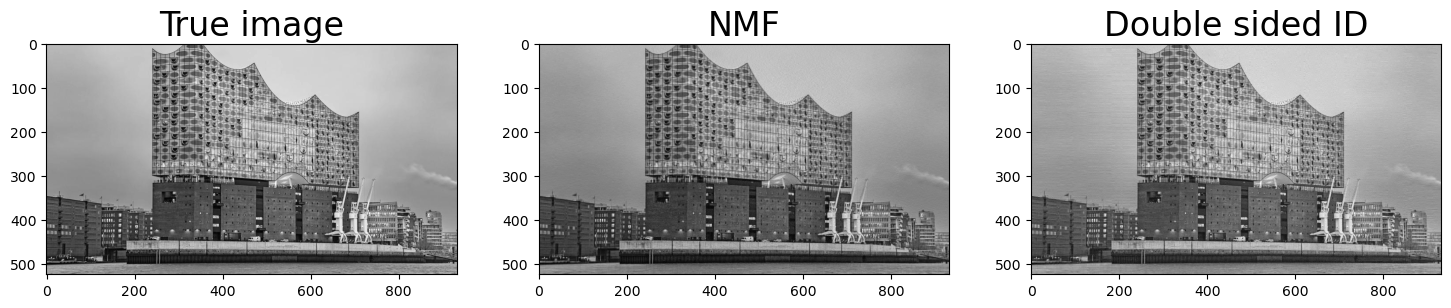

In [21]:
#
# Specify one of the target images here
#
erank = erank_Hamburg
M     = M_Hamburg[:]
JID   = JID_H[:]
#
# NMF 
#
iteration_max = 3500
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

25 0.20515238600181537
50 0.13109813261173492
75 0.10455421915452587
100 0.09044373156778623
125 0.08117982068621846
150 0.07453325716449008
175 0.06955847803883541
200 0.06572639507912272
225 0.06267759830302559
250 0.06019223719320389
275 0.058132557191574605
300 0.05639877312740696
325 0.054919870610952465
350 0.053644058174557654
375 0.052532271697804056
400 0.051554741987782086
425 0.05068841225860711
Time spent in the non-negative matrix factorization (NMF) 2.5389137268066406
Norm ratio:  0.049974000332171496  reached in  448 iterations


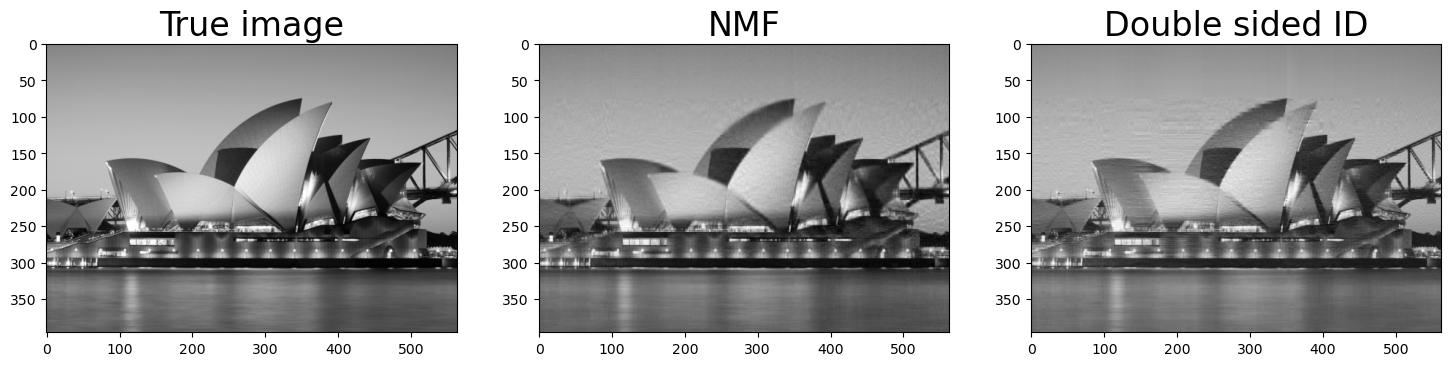

In [18]:
#
# Specify one of the target images here
#
erank = erank_Sydney
M     = M_Sydney[:]
JID   = JID_S[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

25 0.2011634955462465
50 0.1547115820203808
75 0.1280074894653879
100 0.10823001413450273
125 0.09515542795927631
150 0.08640160534143476
175 0.08005545545036029
200 0.07520727687027501
225 0.0713701155172179
250 0.06824728255913996
275 0.06565222846337058
300 0.0634586592268294
325 0.06157582217948967
350 0.05993773966020821
375 0.05849649279542714
400 0.05721671758679402
425 0.05607155684475721
450 0.055040149537711594
475 0.054105951699351486
500 0.05325555728207977
525 0.052478034020423975
550 0.05176442411838511
575 0.05110726422249099
600 0.05050023640301481
Time spent in the non-negative matrix factorization (NMF) 28.432298183441162
Norm ratio:  0.04998138757614055  reached in  623 iterations


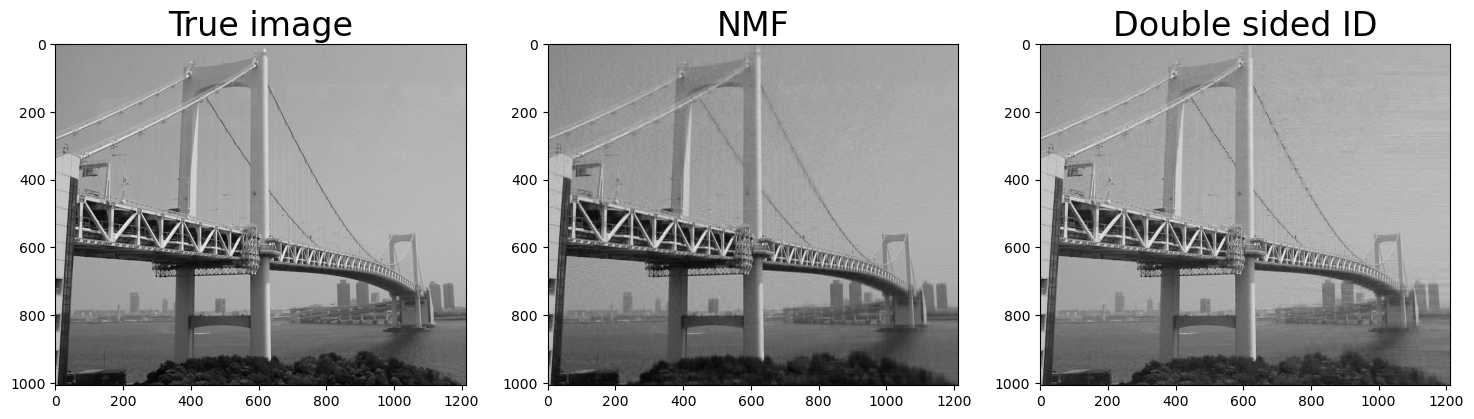

In [19]:
#
# Specify one of the target images here
#
erank = erank_Tokyo
M     = M_Tokyo[:]
JID   = JID_T[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Questions:

* D.1 Pour $\epsilon=0.05$, indiquer pour chacune des images le temps de restitution et le nombre d'itérations. Commenter la vitesse de convergence de la méthode et la qualité de l'image reconstruite.

**Réponse**:
$ \\ $
Hamburg : 3074 iterations in 144.26254773139954s
$ \\ $
Sydney : 448 iterations in 2.53s
$ \\ $
Tokyo : 623 iterations in 28.432298183441162s
$ \\ $

-L'algorithme de Lee et Cheung donne une reconstruction de meilleure qualité que l'algorithme CUR-ID. Le temps de convergence dépend fortement de l'image initiale. L'algorithme de Lee et Cheung utilise une méthode de descente de gradient, ce qui permet une convergence plus rapide lorsque l'image initiale est proche de l'originale. Pour l'image de Hambourg, la mauvaise approximation de faible rang de l'image originale entraîne une vitesse de convergence lente. Afin de résoudre ce problème et d'anticiper ces cas difficiles, il est possible de calculer les premières valeurs singulières de la matrice pour déterminer si l'approximation de faible rang de l'image originale est de bonne qualité. Si c'est le cas, l'algorithme de Lee et Cheung peut être utilisé. Sinon, l'algorithme CUR-ID peut être employé.


* D.2 A chaque fois, nous avons considéré une image exacte dans chacun des algorithmes pour en déduire une approximation de rang faible. Comment obtenir une approximation de rang faible si l'on dispose uniquement d'une image de qualité médiocre comme image initiale ? Proposez un algorithme. 

**Réponse**:

-On peut utiliser l'algorithme de Lee et Cheung pour obtenir une approximation de faible rang d'une image de mauvaise qualité. En effet, l'algorithme de Lee et Cheung utilise une méthode de descente de gradient. Nous pouvons donc utiliser cette méthode pour obtenir une approximation de faible rang d'une image de mauvaise qualité.

* Bonus Quel(s) algorithme(s) utiliseriez-vous pour approcher (au sens de l'approximation de rang faible) non pas une image mais une séquence d'images (donnée par exemple au sein d'une video) ? 

**Réponse**:
Pour approximer une séquence d'images, on peut utiliser des méthodes basées sur la décomposition en valeurs singulières (SVD) ou sur la factorisation matricielle non négative (NMF).

### Références  (articles et exposés)

## Articles

* D. Lee and S. Cheung. <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Algorithms for Non-negative Matrix Factorization </a>. Advances in Neural Information Processing Systems 13 (NIPS 2000). 


* P.-G.  Martinsson.  <a href="https://arxiv.org/pdf/1607.01649.pdf">Randomized  methods  for  matrix  computations</a>.  In  M.W.  Mahoney,  J.C.  Duchi,  and  A.C.  Gilbert, editors, The Mathematics of Data, volume 25, chapter 4, pages 187 – 231. American Mathematical Society, IAS/ParkCity Mathematics Series, 2018.


* P.-G.  Martinsson and J. Tropp.  <a href="https://arxiv.org/pdf/2002.01387.pdf">Randomized Numerical Linear Algebra: Foundations & Algorithms</a>. Acta Numerica, 29, pp 403-572, 2020.


* S. Voronin, P.-G.  Martinsson and  <a href="https://users.oden.utexas.edu/~pgm/Pubs/2017_voronin_CUR.pdf">Efficient Algorithms for CUR and Interpolative Matrix Decompositions</a>. Advances in Computational Mathematics, Volume 43, Issue 3, pp 495–516, 2017.

## Exposés

* P.-G.  Martinsson. <a href="https://simons.berkeley.edu/talks/randomized-algorithms-computing-full-matrix-factorizations">Randomized Algorithms for Computing Full Matrix Factorizations</a>, talk given at  
Randomized Numerical Linear Algebra and Applications, September 2018, Simons Institute, Berkeley, 2018.


* P.-G.  Martinsson. <a href="https://www.youtube.com/watch?v=l262Qij6flM">Randomized algorithms for pivoting and for computing interpolatory and CUR factorizations</a>, talk given at E-Numerical Linear Algebra seminars, March 2021.
